In [1]:
# Basic import necessary for configuration.
import os
import warnings

maindir = os.path.join(os.getcwd(), '../Data/')

In [2]:
# ----------------------General Imports----------------------
import numpy as np
warnings.simplefilter('ignore', np.RankWarning)

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

# -------------------File Download Imports-------------------
from multiprocessing import Pool, cpu_count

In [ ]:
from unrelpix.interpolation import interpolate_dead_pixels

In [4]:
def growing_connected_shape(data, max_size, seed=None):
    """
    Creates a growing connected shape of destroyed pixels.

    Parameters
    ----------
    data : 2D np.ndarray
        Input array.
    max_size : int
        Maximum number of pixels in the connected shape.
    seed : int, optional
        Seed for random number generation. If None, no seed is set.

    Returns
    -------
    np.ndarray
        Copy of `data` with destroyed pixels.
    list of tuple
        Coordinates of the destroyed pixels.
    np.ndarray
        Indices of the destroyed pixels.
    """
    data_backup = data.copy()
    rows, cols = data.shape

    # Set the random seed
    if seed is not None:
        np.random.seed(seed)

    # Start from a random seed point
    start_point = (np.random.randint(0, rows), np.random.randint(0, cols))
    destroyed_pixels = set([start_point])

    # Use a queue for the flood-fill algorithm
    queue = [start_point]

    while len(destroyed_pixels) < max_size and queue:
        current = queue.pop(0)
        neighbors = [  # 4-connectivity
            (current[0] + dr, current[1] + dc)
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]
            if 0 <= current[0] + dr < rows and 0 <= current[1] + dc < cols
        ]
        # Shuffle neighbors to randomize the selection
        np.random.shuffle(neighbors)
        for neighbor in neighbors:
            if neighbor not in destroyed_pixels:
                destroyed_pixels.add(neighbor)
                queue.append(neighbor)
                if len(destroyed_pixels) >= max_size:
                    break

    # Destroy the pixels in the connected shape
    for r, c in destroyed_pixels:
        data_backup[r, c] = np.nan

    # Get the coordinates and flattened indices of the destroyed pixels
    coordinates_to_destroy = list(destroyed_pixels)
    indices_to_destroy = [r * cols + c for r, c in destroyed_pixels]

    return data_backup, coordinates_to_destroy, indices_to_destroy


In [ ]:
def random_holes(data, percentage_to_destroy=0.95, seed=42):
    """
    Randomly destroys a percentage of pixels in the input data.
    Pixels are set to np.nan.

    Parameters
    ----------
    data : 2D np.ndarray
        Input array.
    percentage_to_destroy : float, optional
        Percentage of pixels to destroy (default is 0.95).
    seed : int, optional
        Seed for random number generation (default is 42).

    Returns
    -------
    np.ndarray
        Copy of `data` with destroyed pixels.
    list of tuple
        Coordinates of the destroyed pixels.
    np.ndarray
        Indices of the destroyed pixels.
    """

    np.random.seed(seed)
    data_backup = data.copy()

    # Find the indices of the pixels to destroy
    num_pixels = np.sum(~np.isnan(data))  # Count only non-NaN pixels
    num_pixels_to_destroy = int(num_pixels * percentage_to_destroy)
    indices_to_destroy = np.random.choice(np.where(~np.isnan(data.flatten()))[0], num_pixels_to_destroy, replace=False)

    # Destroy the pixels with either np.nan or random large number
    for idx in indices_to_destroy:
        data_backup.flat[idx] = np.nan

    # using data.shape and data.size from indeces_to_destroy turn into [[x,y],[x,y],..
    coordinates_to_destroy = [np.unravel_index(idx, data.shape) for idx in indices_to_destroy]

    return data_backup, coordinates_to_destroy, indices_to_destroy


def percentage(data, interpolated_data, indices_to_destroy):
    """
    Calculate the percentage of recovered pixels close to the original pixels.
    
    Parameters
    ----------
    data : 2D np.ndarray
        Original data array with some pixels set to np.nan.
    interpolated_data : 2D np.ndarray
        Interpolated data array with the same shape as `data`.
    indices_to_destroy : list of int
        Indices of the pixels that were destroyed in the original data.
    
    Returns
    -------
    float
        Average percentage of recovered pixels close to the original pixels.
    """
    
    original_pixels = np.array([data.flatten()[i] for i in indices_to_destroy])
    interpolated_pixels = np.array([interpolated_data.flatten()[i] for i in indices_to_destroy])
    interpolated_pixels = np.nan_to_num(interpolated_pixels, nan=0)

    # Calculate the average percentage of recovered pixels close to the real pixel
    ratio = interpolated_pixels / original_pixels
    ratio[ratio > 1] = original_pixels[ratio > 1] / interpolated_pixels[ratio > 1]  # Perform original/interpolated where ratio > 1
    average_percentage = np.mean(ratio)
    return average_percentage

In [ ]:
from scipy.interpolate import griddata

def interpolate_with_grid(data, coordinates_to_destroy, method='nearest'):
    """
    Interpolates the destroyed pixels using griddata (scattered interpolation).

    Parameters
    ----------
    data : 2D np.ndarray
        Input array with "destroyed" pixels.
    coordinates_to_destroy : list of tuples
        List of coordinates of the destroyed pixels.
    method : str
        Interpolation method ('linear', 'nearest', 'cubic').

    Returns
    -------
    np.ndarray
        Copy of `data` with destroyed pixels interpolated.
    """
    
    data_interp = data.copy()

    # Mask of valid points
    mask = np.ones(data.shape, dtype=bool)
    for x, y in coordinates_to_destroy:
        mask[x, y] = False

    # Get coordinates of valid and destroyed points
    valid_coords = np.argwhere(mask)
    destroyed_coords = np.array(coordinates_to_destroy)
    valid_values = data[mask]

    # Interpolate
    interpolated_values = griddata(valid_coords, valid_values, destroyed_coords, method=method)

    # Assign back to data
    for (x, y), val in zip(destroyed_coords, interpolated_values):
        data_interp[x, y] = val

    return data_interp

In [7]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = np.loadtxt("data_slice.txt")
data = data - np.nanmin(data) + 1

percentages = np.linspace(0.01, 0.75, 50)
seeds = list(range(40, 50))
ks = list(range(1, 5))
radius = list(range(1, 12))
interp_radius = list(range(1, 30))

def process_seed(seed, destroyed, r, ir, k):
    destroyed_data, _, indices = random_holes(data, destroyed, seed)
    interp = interpolate_dead_pixels(destroyed_data, r, ir, k)
    return seed, destroyed, r, ir, k, percentage(data, interp, indices)

# Prepare all combinations
from itertools import product
param_combinations = list(product(seeds, percentages, radius, interp_radius, ks))

# Run in parallel for all combinations
results = Parallel(n_jobs=-1)(
    delayed(process_seed)(seed, destroyed,  r, ir, k)
    for seed, destroyed, r, ir, k in param_combinations
)

# Organize results into a 5D numpy array: (len(seeds), len(percentages), len(ks), len(radius), len(interp_radius))
shape = (len(seeds), len(percentages), len(radius), len(interp_radius), len(ks))
results_grid = np.full(shape, np.nan)

for entry in results:
    seed, destroyed, r, ir, k, res = entry
    s_idx = seeds.index(seed)
    p_idx = np.abs(percentages - destroyed).argmin()
    k_idx = ks.index(k)
    r_idx = radius.index(r)
    ir_idx = interp_radius.index(ir)
    results_grid[s_idx, p_idx, r_idx, ir_idx, k_idx] = res

# Example: results_grid[p, k, r, ir, s] gives the recovery for that configuration

#marginalize
k_marg = np.nanmean(results_grid, axis=(0, 2, 3)) 
r_marg = np.nanmean(results_grid, axis=(0, 3, 4))
ir_marg = np.nanmean(results_grid, axis=(0, 2, 4))

k_std = np.nanstd(results_grid, axis=(0, 1, 2, 3))
r_std = np.nanstd(results_grid, axis=(0, 1, 3, 4))
ir_std = np.nanstd(results_grid, axis=(0, 1, 2, 4))

In [ ]:
from matplotlib.colors import LinearSegmentedColormap


def negative_cmap(cmap):
    """
    Create a negative version of a colormap by inverting its colors.
    
    Parameters
    ----------
    cmap : matplotlib.colors.Colormap
        The colormap to be inverted.
    
    Returns
    -------
    LinearSegmentedColormap
        A new colormap with inverted colors.
    """
    
    # Extract the colormap's colors as a sequence of (R, G, B) tuples
    colors = cmap(np.linspace(0, 1, 256))[:, :3]  # Ignore alpha channel

    # Invert the colors (subtract from 1)
    inverted_colors = 1 - colors

    # Create a new colormap with the inverted colors
    return LinearSegmentedColormap.from_list('negative_' + cmap.name, inverted_colors)

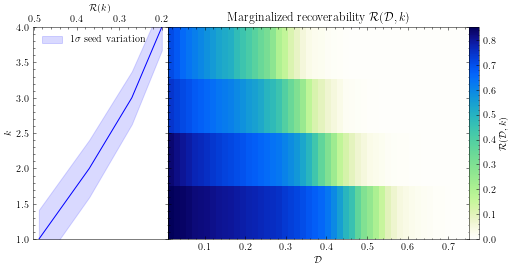

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Adjusted figure size
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(6, 3, width_ratios=[9, 20, 0.7], height_ratios=[
                       0.3, 1, 0.5, 1, 0.3, 1]) 

# Marginalized likelihood
ax_2d_1 = fig.add_subplot(gs[1, 1])
cbar_ax_1 = fig.add_subplot(gs[1, 2])  # Color bar for the first plot
im1 = ax_2d_1.imshow(k_marg.T, extent=(percentages[0], percentages[-1], ks[0], ks[-1]),
                     aspect='auto', origin='lower', cmap=negative_cmap(plt.cm.inferno))
cbar = plt.colorbar(im1, cax=cbar_ax_1)
cbar.set_label(r'$\mathcal{R}(\mathcal{D},k)$')
ax_2d_1.set_title(r'Marginalized recoverability $\mathcal{R}(\mathcal{D},k)$')
ax_2d_1.tick_params(axis='x')  # Remove x-axis labels
# Remove y-axis labels as we will share it
ax_2d_1.tick_params(axis='y', labelleft=False)
ax_2d_1.set_xlabel(r'$\mathcal{D}$')

# Add the second plot to the left of the heatmap, flipped 90 degrees
ax_1d_2 = fig.add_subplot(gs[1, 0], sharey=ax_2d_1)

ax_1d_2.plot(np.mean(k_marg, axis=0), ks,  'b-')
ax_1d_2.fill_between(np.mean(k_marg, axis=0),
    ks - k_std, ks + k_std, 
    color='blue', alpha=0.15, label=r'$1\sigma$ seed variation'
)
ax_1d_2.invert_xaxis()  # Flip the x-axis (90-degree rotation effect)
ax_1d_2.set_xlabel(r'$\mathcal{R}(k)$')
ax_1d_2.set_ylabel(r'$k$')
ax_1d_2.set_ylim(ks[0], ks[-1])
ax_1d_2.legend()

# set the x ticks to the right
ax_1d_2.xaxis.set_ticks_position('top')
ax_1d_2.xaxis.set_label_position('top')

# Remove space between the heatmap and new plot
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
# Show the plot
plt.savefig('marg_k.pdf', dpi=300)
plt.show()

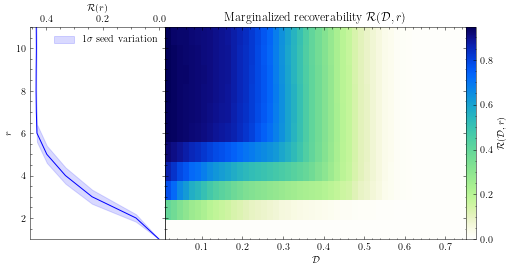

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Adjusted figure size
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(6, 3, width_ratios=[9, 20, 0.7], height_ratios=[
                       0.3, 1, 0.5, 1, 0.3, 1]) 

# Marginalized likelihood
ax_2d_1 = fig.add_subplot(gs[1, 1])
cbar_ax_1 = fig.add_subplot(gs[1, 2])  # Color bar for the first plot
im1 = ax_2d_1.imshow(r_marg.T, extent=(percentages[0], percentages[-1], radius[0], radius[-1]),
                     aspect='auto', origin='lower', cmap=negative_cmap(plt.cm.inferno))
cbar = plt.colorbar(im1, cax=cbar_ax_1)
cbar.set_label(r'$\mathcal{R}(\mathcal{D},r)$')
ax_2d_1.set_title(r'Marginalized recoverability $\mathcal{R}(\mathcal{D},r)$')
ax_2d_1.tick_params(axis='x')  # Remove x-axis labels
# Remove y-axis labels as we will share it
ax_2d_1.tick_params(axis='y', labelleft=False)
ax_2d_1.set_xlabel(r'$\mathcal{D}$')

# Add the second plot to the left of the heatmap, flipped 90 degrees
ax_1d_2 = fig.add_subplot(gs[1, 0], sharey=ax_2d_1)

ax_1d_2.plot(np.mean(r_marg, axis=0), radius,  'b-')
ax_1d_2.fill_between(np.mean(r_marg, axis=0),
    radius - r_std, radius + r_std, 
    color='blue', alpha=0.15, label=r'$1\sigma$ seed variation'
)
ax_1d_2.invert_xaxis()  # Flip the x-axis (90-degree rotation effect)
ax_1d_2.set_xlabel(r'$\mathcal{R}(r)$')
ax_1d_2.set_ylabel(r'$r$')
ax_1d_2.set_ylim(radius[0], radius[-1])
ax_1d_2.legend()


# set the x ticks to the right
ax_1d_2.xaxis.set_ticks_position('top')
ax_1d_2.xaxis.set_label_position('top')

# Remove space between the heatmap and new plot
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
# Show the plot
plt.savefig('marg_r.pdf', dpi=300)
plt.show()

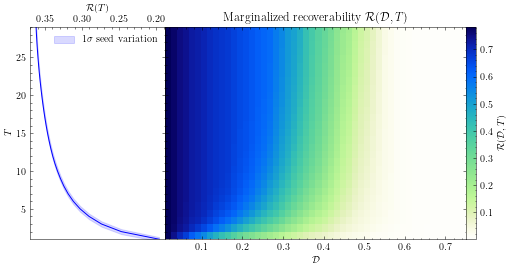

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Adjusted figure size
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(6, 3, width_ratios=[9, 20, 0.7], height_ratios=[
                       0.3, 1, 0.5, 1, 0.3, 1]) 

# Marginalized likelihood
ax_2d_1 = fig.add_subplot(gs[1, 1])
cbar_ax_1 = fig.add_subplot(gs[1, 2])  # Color bar for the first plot
im1 = ax_2d_1.imshow(ir_marg.T, extent=(percentages[0], percentages[-1], interp_radius[0], interp_radius[-1]),
                     aspect='auto', origin='lower', cmap=negative_cmap(plt.cm.inferno))
cbar = plt.colorbar(im1, cax=cbar_ax_1)
cbar.set_label(r'$\mathcal{R}(\mathcal{D}, T)$')
ax_2d_1.set_title(r'Marginalized recoverability $\mathcal{R}(\mathcal{D},T)$')
ax_2d_1.tick_params(axis='x')  # Remove x-axis labels
# Remove y-axis labels as we will share it
ax_2d_1.tick_params(axis='y', labelleft=False)
ax_2d_1.set_xlabel(r'$\mathcal{D}$')

# Add the second plot to the left of the heatmap, flipped 90 degrees
ax_1d_2 = fig.add_subplot(gs[1, 0], sharey=ax_2d_1)

ax_1d_2.plot(np.mean(ir_marg, axis=0), interp_radius,  'b-')
ax_1d_2.fill_between(np.mean(ir_marg, axis=0),
    interp_radius - ir_std, interp_radius + ir_std, 
    color='blue', alpha=0.15, label=r'$1\sigma$ seed variation'
)
ax_1d_2.invert_xaxis()  # Flip the x-axis (90-degree rotation effect)
ax_1d_2.set_xlabel(r'$\mathcal{R}(T)$')
ax_1d_2.set_ylabel(r'$T$')
ax_1d_2.set_ylim(interp_radius[0], interp_radius[-1])
ax_1d_2.legend()


# set the x ticks to the right
ax_1d_2.xaxis.set_ticks_position('top')
ax_1d_2.xaxis.set_label_position('top')

# Remove space between the heatmap and new plot
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
# Show the plot
plt.savefig('marg_ir.pdf', dpi=300)
plt.show()

In [7]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = np.loadtxt("data_slice.txt")
data = data - np.nanmin(data) + 1

percentages = np.linspace(0.01, 0.75, 100)
seeds = range(40, 106)

def process_seed(seed):
    results = {k: [] for k in ['new', 'nearest', 'linear', 'cubic']}
    for destroyed_percentage in percentages:
        destroyed_data, coords, indices = random_holes(data, destroyed_percentage, seed)

        # new
        interp_new = interpolate_dead_pixels(destroyed_data, 6, 24, 1)
        results['new'].append(percentage(data, interp_new, indices))

        # nearest
        interp_nearest = interpolate_with_grid(destroyed_data, coords, method='nearest')
        interp_nearest[np.isnan(interp_new)] = 0
        results['nearest'].append(percentage(data, interp_nearest, indices))

        # linear
        interp_linear = interpolate_with_grid(destroyed_data, coords, method='linear')
        interp_linear[np.isnan(interp_new)] = 0
        results['linear'].append(percentage(data, interp_linear, indices))

        # cubic
        interp_cubic = interpolate_with_grid(destroyed_data, coords, method='cubic')
        interp_cubic[np.isnan(interp_new)] = 0
        results['cubic'].append(percentage(data, interp_cubic, indices))

    return seed, results['new'], results['nearest'], results['linear'], results['cubic']

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(process_seed)(seed) for seed in seeds)

# Unpack results into dict of lists
keys = ['new', 'nearest', 'linear', 'cubic']
percentages_results = {k: np.array([r[i+1] for r in results]) for i, k in enumerate(keys)}

# Compute statistics
stats = {}
for k in keys:
    arr = percentages_results[k]
    stats[k] = {
        'min': arr.min(axis=0),
        'max': arr.max(axis=0),
        'mean': arr.mean(axis=0),
        'std': arr.std(axis=0),
    }

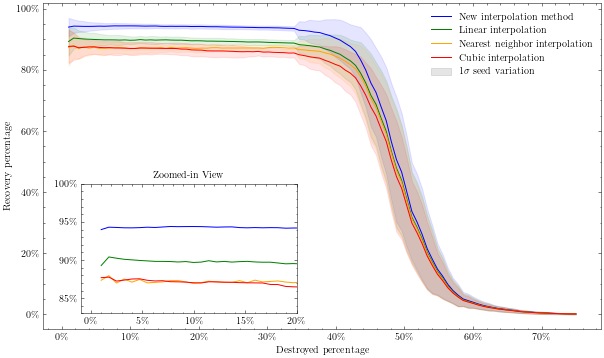

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# Define colors and labels for each interpolation
styles = {
    'new':     {'color': 'blue',   'label': 'New interpolation method'},
    'linear':  {'color': 'green',  'label': 'Linear interpolation'},
    'nearest': {'color': 'orange', 'label': 'Nearest neighbor interpolation'},
    'cubic':   {'color': 'red',    'label': 'Cubic interpolation'},
}

plt.figure(figsize=(10, 6))

# Plot mean and std bands for each interpolation
for k, style in styles.items():
    mean = stats[k]['mean']
    std = stats[k]['std']
    color = style['color']
    label = style['label']

    plt.plot(percentages, mean, color=color, label=label)
    plt.fill_between(
        percentages, mean - std, mean + std,
        color=color, alpha=0.1
    )

# Invisible patch for legend's seed variation
plt.fill_between([], [], [], color='black', alpha=0.1, label=r'$1\sigma$ seed variation')

plt.xlabel('Destroyed percentage')
plt.ylabel('Recovery percentage')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.0f}\%"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}\%"))
plt.legend()

# Inset axis
ax_inset = inset_axes(
    plt.gca(),
    width="30%", height="30%",
    loc="lower left",
    bbox_to_anchor=(0.17, 0.15, 1, 1),
    bbox_transform=plt.gcf().transFigure
)

# Plot inset lines without fill
for k, style in styles.items():
    ax_inset.plot(percentages, stats[k]['mean'], color=style['color'])

# Format inset
ax_inset.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.0f}\%"))
ax_inset.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}\%"))
ax_inset.set_xlim(-0.01, 0.2)
ax_inset.set_ylim(0.83, 1.0)
ax_inset.set_title("Zoomed-in View", fontsize=10)
plt.savefig('pixels_removed.pdf', dpi=300)
plt.show()

In [7]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = np.loadtxt("data_slice.txt")
data = data - np.nanmin(data) + 1

percentage_no = 90
percentages = np.linspace(0, 90, percentage_no)
seeds = range(40, 106)

def process_seed(seed):
    results = {k: [] for k in ['new', 'nearest', 'linear', 'cubic']}
    for destroyed_percentage in percentages:
        destroyed_data, coords, indices = growing_connected_shape(data, destroyed_percentage, seed)

        # new
        interp_new = interpolate_dead_pixels(destroyed_data, 6, 24, 1)
        results['new'].append(percentage(data, interp_new, indices))

        # nearest
        interp_nearest = interpolate_with_grid(destroyed_data, coords, method='nearest')
        interp_nearest[np.isnan(interp_new)] = 0
        results['nearest'].append(percentage(data, interp_nearest, indices))

        # linear
        interp_linear = interpolate_with_grid(destroyed_data, coords, method='linear')
        interp_linear[np.isnan(interp_new)] = 0
        results['linear'].append(percentage(data, interp_linear, indices))

        # cubic
        interp_cubic = interpolate_with_grid(destroyed_data, coords, method='cubic')
        interp_cubic[np.isnan(interp_new)] = 0
        results['cubic'].append(percentage(data, interp_cubic, indices))

    return seed, results['new'], results['nearest'], results['linear'], results['cubic']

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(process_seed)(seed) for seed in seeds)

# Unpack results into dict of lists
keys = ['new', 'nearest', 'linear', 'cubic']
percentages_results = {k: np.array([r[i+1] for r in results]) for i, k in enumerate(keys)}

# Compute statistics
stats = {}
for k in keys:
    arr = percentages_results[k]
    stats[k] = {
        'min': arr.min(axis=0),
        'max': arr.max(axis=0),
        'mean': arr.mean(axis=0),
        'std': arr.std(axis=0),
    }

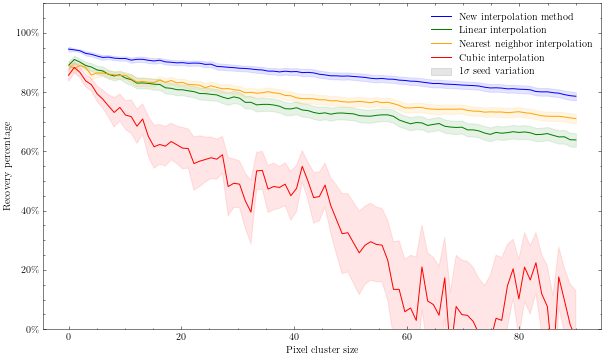

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# Define colors and labels for each interpolation
styles = {
    'new':     {'color': 'blue',   'label': 'New interpolation method'},
    'linear':  {'color': 'green',  'label': 'Linear interpolation'},
    'nearest': {'color': 'orange', 'label': 'Nearest neighbor interpolation'},
    'cubic':   {'color': 'red',    'label': 'Cubic interpolation'},
}

plt.figure(figsize=(10, 6))

# Plot mean and std bands for each interpolation
for k, style in styles.items():
    mean = stats[k]['mean']
    std = stats[k]['std'] / 10
    color = style['color']
    label = style['label']

    plt.plot(percentages, mean, color=color, label=label)
    plt.fill_between(
        percentages, mean - std, mean + std,
        color=color, alpha=0.1
    )

# Invisible patch for legend's seed variation
plt.fill_between([], [], [], color='black', alpha=0.1, label=r'$1\sigma$ seed variation')

plt.xlabel('Pixel cluster size')
plt.ylabel('Recovery percentage')
plt.ylim(0, 1.1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}\%"))
plt.legend()
plt.savefig('pixel_cluster.pdf', dpi=300)
plt.show()
